---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**


----------------
## Caveats
### Demonstrating known caveats in `spaghetti`

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook demonstrates the following limitations and caveats:**

1. Limitations in non-planarity
2. Distance matrices between (dis)connected components
3. zzzz

In [2]:
%load_ext watermark
%watermark

2020-03-10T08:22:01-04:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.3.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [36]:
import geopandas
import libpysal
from libpysal.cg import Point, Chain
import matplotlib
import matplotlib.pyplot as plt
import numpy
import spaghetti
%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
numpy      1.17.3
libpysal   4.2.0
spaghetti  1.4.2.post2
geopandas  0.6.2
matplotlib 3.1.2



In [37]:
try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina")
except ImportError:
    pass

-----------------------
### 1. Limitations in non-planarity
#### a) Barbed wire example
##### Create some line segments of ``libpysal.cg.Chain`` objects

In [38]:
lines = [
    Chain([Point((2,7)), Point((2,3))]),
    Chain([Point((2,3)), Point((0,3))]),
    Chain([Point((0,3)), Point((0,5))]),
    Chain([Point((0,5)), Point((5,5))]),
    Chain([Point((5,5)), Point((5,7))]),
    Chain([Point((5,7)), Point((3,7))]),
    Chain([Point((3,7)), Point((3,3))])
]
lines

##### Instantiate a ``spaghetti.Network`` object

In [39]:
ntw = spaghetti.Network(in_data=lines)

##### Extract the network vertices and arcs

In [40]:
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
vertices_df

,id,geometry,comp_label
0,0,POINT (2.00000 7.00000),0
1,1,POINT (2.00000 3.00000),0
2,2,POINT (0.00000 3.00000),0
3,3,POINT (0.00000 5.00000),0
4,4,POINT (5.00000 5.00000),0
5,5,POINT (5.00000 7.00000),0
6,6,POINT (3.00000 7.00000),0
7,7,POINT (3.00000 3.00000),0


In [41]:
arcs_df

,id,geometry,comp_label
0,"(0, 1)","LINESTRING (2.00000 7.00000, 2.00000 3.00000)",0
1,"(1, 2)","LINESTRING (2.00000 3.00000, 0.00000 3.00000)",0
2,"(2, 3)","LINESTRING (0.00000 3.00000, 0.00000 5.00000)",0
3,"(3, 4)","LINESTRING (0.00000 5.00000, 5.00000 5.00000)",0
4,"(4, 5)","LINESTRING (5.00000 5.00000, 5.00000 7.00000)",0
5,"(5, 6)","LINESTRING (5.00000 7.00000, 3.00000 7.00000)",0
6,"(6, 7)","LINESTRING (3.00000 7.00000, 3.00000 3.00000)",0


##### Plot

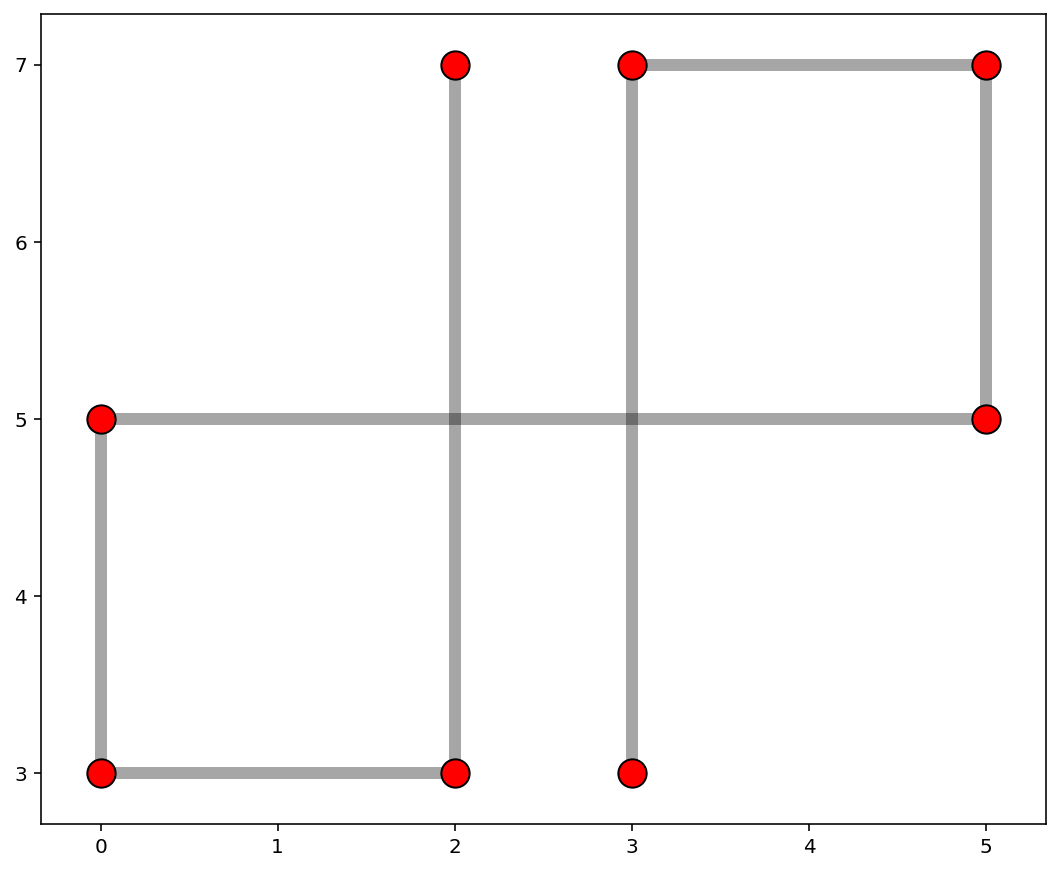

In [42]:
base = arcs_df.plot(lw=6, color="k", alpha=.35, figsize=(9, 9))
vertices_df.plot(ax=base, fc="r", ec="k", markersize=200, zorder=2)

The plot above shows newtowk arcs in gray and vertices in red. 

---------------------

#### b) Goalpost example
##### Create some line segments of ``libpysal.cg.Chain`` objects

In [43]:
U = [Chain([Point((2,2)), Point((2,1)), Point((4,1)), Point((4,2))])]
I = [Chain([Point((3,0)), Point((3,1))])]
arcs = U + I
arcs

##### Instantiate a ``spaghetti.Network`` object

ntw = spaghetti.Network(in_data=arcs)

##### Examine the componets
**There are two components:**

In [45]:
ntw.network_n_components

2

**Component ``0`` includes 4 vertices (the "goal") and component ``1`` includes 2 (the "post"):**

In [46]:
ntw.network_component_vertices

{0: [0, 1, 2, 3], 1: [4, 5]}

##### Extract the network vertices and arcs

In [47]:
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
vertices_df

,id,geometry,comp_label
0,0,POINT (2.00000 2.00000),0
1,1,POINT (2.00000 1.00000),0
2,2,POINT (4.00000 1.00000),0
3,3,POINT (4.00000 2.00000),0
4,4,POINT (3.00000 0.00000),1
5,5,POINT (3.00000 1.00000),1


In [48]:
arcs_df

,id,geometry,comp_label
0,"(0, 1)","LINESTRING (2.00000 2.00000, 2.00000 1.00000)",0
1,"(1, 2)","LINESTRING (2.00000 1.00000, 4.00000 1.00000)",0
2,"(2, 3)","LINESTRING (4.00000 1.00000, 4.00000 2.00000)",0
3,"(4, 5)","LINESTRING (3.00000 0.00000, 3.00000 1.00000)",1


##### Helper function for vertex labeling

In [49]:
def vert_labels(v, b, s):
    """Label each network vertex."""
    def _lab_loc(_x):
        """Internal helper for labeling vertices."""
        return _x.geometry.coords[0]
    kws = {"size": s, "ha": "left", "va": "bottom", "weight": "bold"}
    v.apply(lambda x: b.annotate(s=x.comp_label, xy=_lab_loc(x), **kws), axis=1)       

##### Plot

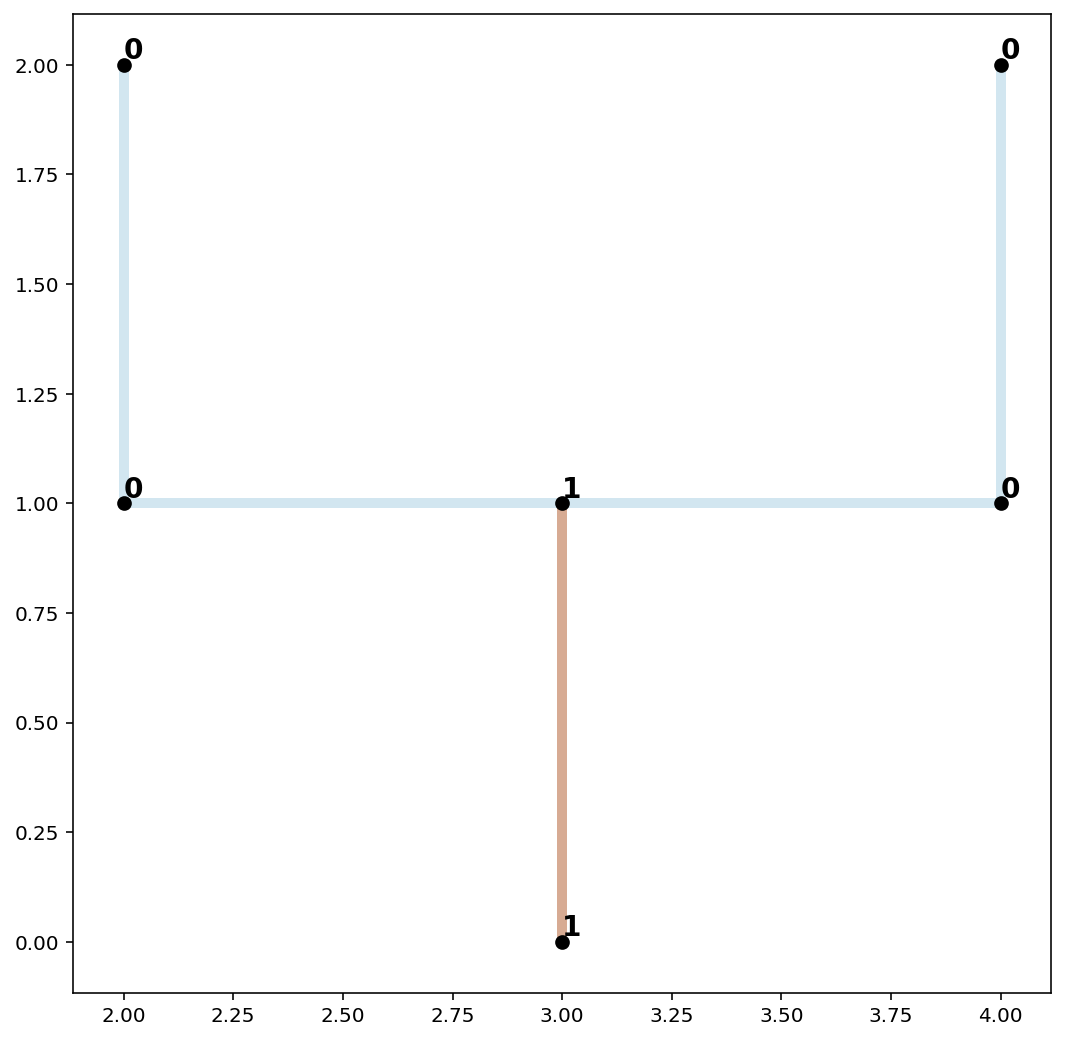

In [55]:
base_kws = {"alpha":.5, "lw":5, "cmap":"Paired", "column":"comp_label"}
base = arcs_df.plot(figsize=(9, 9), **base_kws)
vertices_df.plot(ax=base, color="k", markersize=40, zorder=2)
# vertex labels
vert_labels(vertices_df, base, 14)

**As stated previously, flow from one network segment to another is only possible when segments share a vertex. In this case, no vertex is actually shared, although superficially there does appear to be. The plot above visualizes this concept by showing the two (dis)connected components of the "goalpost" network. Network arcs are colored by component membership and vertices are labeled by component membership.**

-----------------------
### 2. Distance matrices for multiple connected components
#### Continuing with the "goalpost" network

-----------------------